# Prédiction du Statut de Compte Client avec un Pipeline MLOps 

# Alseny
## Data Scientist / Machine Learning Engineer

# Introduction

Dans un contexte où la gestion proactive de la relation client est cruciale, ce projet a pour objectif de prédire automatiquement le statut d’un compte client (account_status) à partir de ses caractéristiques comportementales et démographiques. Grâce à une approche MLOps, ce projet intègre les meilleures pratiques de science des données, de déploiement et de surveillance des modèles en production.

Ce projet permet de :

Prédire en temps réel si un compte est actif, inactif, ou à risque

Visualiser les performances du modèle et détecter les dérives

Suivre les expériences via MLflow

Fournir une API REST
Automatiser le tout via GitHub Actions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Bibliothèque de base pour la visualisation
import seaborn as sns
import plotly.express as px
import joblib
import mlflow
import mlflow.sklearn
from datetime import datetime
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#import Utils

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

# Importation du dataset

In [3]:
CustomerData = pd.read_csv("/home/sacko/Documents/PredictionStatutCompte/Donnees/customer_data.csv")
print(CustomerData.shape)
CustomerData.head() # - Affichage des premières lignes du jeu de données pour visualiser rapidement la structure et les premières valeurs.

(1000000, 20)


,customer_id,first_name,last_name,gender,birth_date,marital_status,employment_status,education_level,job_title,annual_income,number_of_children,email,phone_number,address,city,state,zip_code,country,account_status,subscription_type
0,124c274f-9b56-46b5-845e-37eb61edef16,Jacob,Snyder,Female,1996-08-06,Single,Unemployed,Other,Data scientist,94321.32,1,phamchristopher@example.net,+1-454-214-4238x10683,"746 Pacheco Parks, West Joshuatown, ME 32351",Sanchezview,Iowa,73895.0,Zambia,Inactive,Free
1,26a3aac2-0c11-4c97-83f9-4fbfebba4e8f,Melanie,Barnes,Male,1960-07-15,Widowed,NaN,PhD,"Psychologist, prison and probation services",187455.93,4,amiles@example.net,528-316-8290x7168,"98084 Jessica Street Suite 063, Rubiofort, CO ...",Lake Joseside,Mississippi,51816.0,Greenland,Suspended,Free
2,87fbb281-1327-4231-bf8a-7278487962be,Robert,Randall,Other,1964-02-03,Single,Unemployed,PhD,Chief Technology Officer,85946.69,2,charlotterocha@example.com,001-924-794-0179,"6383 Murphy Bridge Apt. 545, Luisborough, VA 0...",Lake Adamhaven,Virginia,81666.0,Greece,Active,Basic
3,9e9d413d-2b08-4650-9adc-107ae095b49b,NaN,NaN,Other,1947-01-07,Married,Employed,Bachelor,Systems developer,111074.34,0,fallen@example.org,001-867-358-4691x06683,"9319 Castillo Corners, Brittanyport, MI 77082",Port Shannonhaven,Rhode Island,87917.0,Burkina Faso,Inactive,Premium
4,17bce622-f80e-4515-ade1-249f1d093c7e,Shaun,Collins,Female,1962-03-02,Married,Employed,Master,"Surveyor, building control",131036.67,1,ucrawford@example.com,(372)383-7859x649,"806 James Lane Suite 928, North Joshuastad, OH...",New Mariatown,Pennsylvania,36690.0,Slovenia,Active,Basic


Variable dérivée	Utile ?	Pourquoi ?

✅ age_group	Oui	Permet de capturer des comportements selon l’âge

✅ children_per_age	Oui	Représente une charge familiale pondérée

✅ is_married	Oui	Le statut marital peut influencer la fidélité

✅ education_group	Oui	Simplifie une variable souvent trop granulaire

✅ income_group	Oui	Mieux que le revenu brut ou log pour classifier

✅ is_employed_stable	Oui	La stabilité peut affecter la propension à rester
⚠

# Pré-nettoyage

In [4]:
# Création d'une copie des données clients
df_customer = CustomerData.copy()

In [5]:
# Fonction pour convertir birth_date en âge
def birth_date_to_age(X):
    today = pd.to_datetime('today')
    df_customer['age'] = pd.to_datetime(df_customer['birth_date']).apply(
        lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day))
    )
    return df_customer.drop(columns=['birth_date'])

# Pipeline avec FunctionTransformer
age_pipeline = Pipeline([
    ('birth_to_age', FunctionTransformer(birth_date_to_age))
])

df_customer = birth_date_to_age(df_customer)

df_customer.columns

Index(['customer_id', 'first_name', 'last_name', 'gender', 'marital_status',
       'employment_status', 'education_level', 'job_title', 'annual_income',
       'number_of_children', 'email', 'phone_number', 'address', 'city',
       'state', 'zip_code', 'country', 'account_status', 'subscription_type',
       'age'],
      dtype='object')

In [6]:
df_customer.marital_status.value_counts()

marital_status
Widowed     245160
Divorced    245076
Single      245030
Married     244800
Name: count, dtype: int64

In [7]:
# Filtrage des variables
selected_features = [
    'account_status',
    'gender',
    'age',         # à transformer en âge
    'marital_status',
    'employment_status',
    'education_level',
    #'job_title',            # à transformer ou regrouper
    'annual_income',
    'number_of_children',
    #'city',
    #'state',
    'country',
    'subscription_type'
]

df_customer = df_customer[selected_features]
df_customer.head()

,account_status,gender,age,marital_status,employment_status,education_level,annual_income,number_of_children,country,subscription_type
0,Inactive,Female,29.0,Single,Unemployed,Other,94321.32,1,Zambia,Free
1,Suspended,Male,65.0,Widowed,NaN,PhD,187455.93,4,Greenland,Free
2,Active,Other,61.0,Single,Unemployed,PhD,85946.69,2,Greece,Basic
3,Inactive,Other,78.0,Married,Employed,Bachelor,111074.34,0,Burkina Faso,Premium
4,Active,Female,63.0,Married,Employed,Master,131036.67,1,Slovenia,Basic


# Exploration (exploratory data analysis - EDA)

- Résumé du DataFrame (types de variables, nombre de valeurs non nulles, mémoire utilisée)
- Analyse de la variable cible
- Indicateurs statistiques (moyenne, écart-type, min, max, quartiles, mode) pour les colonnes.
- Évaluation de la qualité des données (compter le nombre de valeurs manquantes par colonne, indication du nombre de valeurs distinctes pour chaque colonne, utile pour repérer les variables constantes ou à forte cardinalité, affichage de la fréquence des différentes modalités des variables catégorielles).
- Détection des types de variables
- Recherche de doublons
- Vérification de la distribution marginale des variables
- Identification des valeurs abérantes et extrêmes
- Repartition des données en data_train et data_test
- Vérification que le train test split conserve les bonnes proportions des données

## Résumé du DataFrame

In [8]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   account_status      980033 non-null   object 
 1   gender              979999 non-null   object 
 2   age                 980158 non-null   float64
 3   marital_status      980066 non-null   object 
 4   employment_status   979988 non-null   object 
 5   education_level     980156 non-null   object 
 6   annual_income       1000000 non-null  float64
 7   number_of_children  1000000 non-null  int64  
 8   country             980011 non-null   object 
 9   subscription_type   979800 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 76.3+ MB


## Identification de la nature des variables

In [9]:
# Fonction d'identification de la nature des variables

def compter_variables(dataset):
    """Affiche et compte les variables quantitatives et qualitatives d'un dataset.

    Parameters:
    dataset (pandas.DataFrame): Le DataFrame contenant les variables à analyser.

    """
    # Sélection des colonnes quantitatives (numériques) et qualitatives (non numériques)
    quantitatives = dataset.select_dtypes(include=['number']).columns
    qualitatives = dataset.select_dtypes(exclude=['number']).columns

    # Affichage des colonnes quantitatives et de leur nombre
    print("Les variables quantitatives:\n", quantitatives)
    print(f"Nombre de variables quantitatives : {len(quantitatives)}\n")

    # Affichage des colonnes qualitatives et de leur nombre
    print("Les variables qualitatives:\n", qualitatives)
    print(f"Nombre de variables qualitatives : {len(qualitatives)}")
    

#  Appel de la fonction
compter_variables(df_customer)

Les variables quantitatives:
 Index(['age', 'annual_income', 'number_of_children'], dtype='object')
Nombre de variables quantitatives : 3

Les variables qualitatives:
 Index(['account_status', 'gender', 'marital_status', 'employment_status',
       'education_level', 'country', 'subscription_type'],
      dtype='object')
Nombre de variables qualitatives : 7


## Identification des lignes dupliquées dans le DataFrame

In [10]:
# Identification des lignes dupliquées dans le DataFrame

def duplicated_values_summary(df):
    # Calcul de la somme totale des lignes dupliquées
    total_duplicated_rows = df.duplicated().sum()

    # Identification des colonnes contenant des valeurs dupliquées
    duplicated_columns = [col for col in df.columns if df[col].duplicated().any()]

    # Affichage des résultats
    print("Total de lignes dupliquées dans le DataFrame :", total_duplicated_rows)
    print("Colonnes contenant des valeurs dupliquées :", duplicated_columns)

    return {"total_duplicated_rows": total_duplicated_rows, "duplicated_columns": duplicated_columns}



duplicated_values_summary(df_customer) # Appel de la fonction

Total de lignes dupliquées dans le DataFrame : 0
Colonnes contenant des valeurs dupliquées : ['account_status', 'gender', 'age', 'marital_status', 'employment_status', 'education_level', 'annual_income', 'number_of_children', 'country', 'subscription_type']


{'total_duplicated_rows': np.int64(0),
 'duplicated_columns': ['account_status',
  'gender',
  'age',
  'marital_status',
  'employment_status',
  'education_level',
  'annual_income',
  'number_of_children',
  'country',
  'subscription_type']}

## Alyser de la cible account_status
Vérifie s’il s’agit d’un problème de classification binaire ou multi-classes :

In [11]:
print(df_customer["account_status"].value_counts())

account_status
Suspended    326915
Active       326753
Inactive     326365
Name: count, dtype: int64


<Axes: ylabel='proportion'>

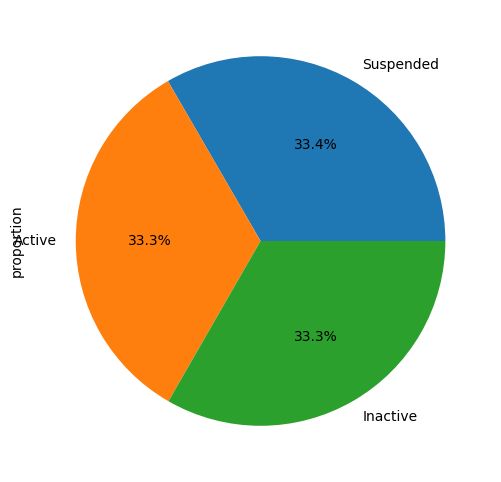

In [12]:
df_customer['account_status'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', figsize=(6, 6))

## Indicateurs statistiques

In [13]:
# Affichage des statistiques descriptives pour toutes les colonnes numériques,
df_customer.describe()

,age,annual_income,number_of_children
count,980158.000000,1.000000e+06,1000000.000000
mean,54.388419,1.176114e+06,2.420123
std,21.082550,1.191776e+07,1.895068
min,18.000000,1.500005e+04,-10.000000
25%,36.000000,6.168157e+04,1.000000
50%,54.000000,1.083261e+05,2.000000
75%,73.000000,1.550781e+05,4.000000
max,91.000000,1.999883e+08,5.000000


In [14]:
# Affichage des statistiques descriptives pour toutes les colonnes catégorielles, y compris les catégorielles
df_customer.describe(include="O")

,account_status,gender,marital_status,employment_status,education_level,country,subscription_type
count,980033,979999,980066,979988,980156,980011,979800
unique,3,3,4,5,5,243,4
top,Suspended,Female,Widowed,Self-employed,Bachelor,Korea,Basic
freq,326915,326808,245160,196243,196885,7993,245421


## Analyse des valeurs manquantes

In [15]:
# Totale de valeurs manquantes dans le data frame
df_customer.isna().sum().sum()

np.int64(159789)

Le jeu de données est rempli à 98.40%
Il a 1.60% de données manquantes




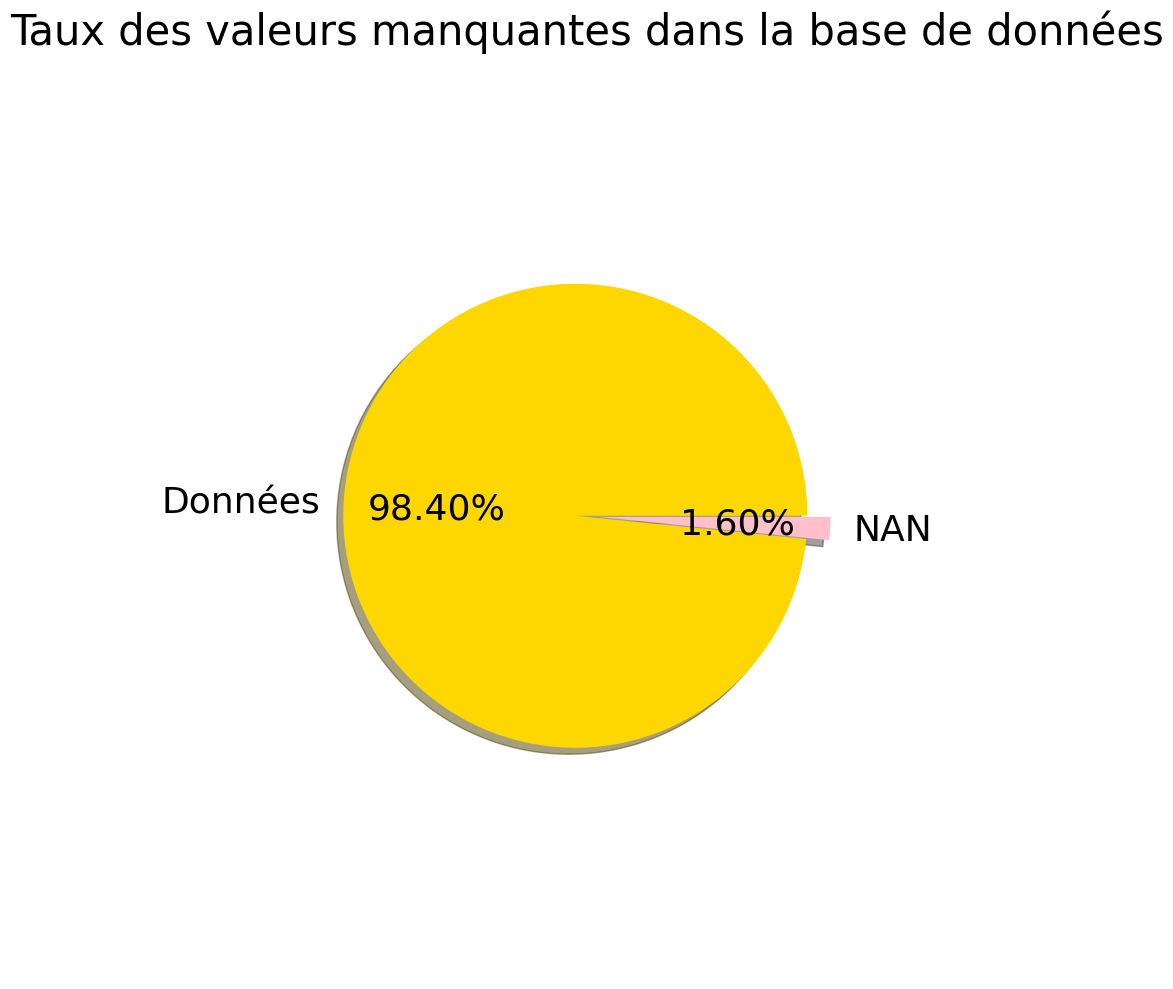

In [16]:
# Comptage du taux de données manquantes dans le DataFrame

def pie_nan(dataframe):
    """Affiche un graphique en camembert montrant le taux de données manquantes dans le DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): Le DataFrame à analyser.
    """
    # Calcul du nombre de lignes et de colonnes
    lignes = dataframe.shape[0]
    colonnes = dataframe.shape[1]

    # Nombre de données non manquantes
    nb_data = dataframe.count().sum()

    # Nombre total de données dans le jeu de données (colonnes * lignes)
    nb_total = colonnes * lignes

    # Taux de remplissage du jeu de données
    rate_data_ok = nb_data / nb_total
    print(f"Le jeu de données est rempli à {rate_data_ok:.2%}")
    print(f"Il a {1 - rate_data_ok:.2%} de données manquantes")
    print("\n")

    # Création du pie chart
    rates = [rate_data_ok, 1 - rate_data_ok]
    labels = ["Données", "NAN"]
    explode = (0, 0.1)
    colors = ['gold', 'pink']

    # Plot
    plt.figure(figsize=(8, 10))
    plt.pie(rates, explode=explode, labels=labels, colors=colors,
            autopct='%.2f%%', shadow=True, textprops={'fontsize': 26})

    # Titre du graphique
    ttl = plt.title("Taux des valeurs manquantes dans la base de données", fontsize=30)
    ttl.set_position([0.5, 0.50])

    # Assurer que le graphique est bien circulaire
    plt.axis('equal')
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


# Application de la fonction de comptage du taux de données manquantes dans le Data Frame
pie_nan(df_customer)

In [17]:
# Affichege du pourcentage de valeurs manquantes par colonne

def show_all_missing(data_set):
    """Calcule et retourne le pourcentage de valeurs manquantes par colonne dans un DataFrame.
    """
    return (data_set.isna().sum() / data_set.shape[0]).sort_values(ascending=True) * 100

    
show_all_missing(df_customer) #  Appel de la fonction d'

annual_income         0.0000
number_of_children    0.0000
age                   1.9842
education_level       1.9844
marital_status        1.9934
account_status        1.9967
country               1.9989
gender                2.0001
employment_status     2.0012
subscription_type     2.0200
dtype: float64

In [18]:
df_customer.describe()

,age,annual_income,number_of_children
count,980158.000000,1.000000e+06,1000000.000000
mean,54.388419,1.176114e+06,2.420123
std,21.082550,1.191776e+07,1.895068
min,18.000000,1.500005e+04,-10.000000
25%,36.000000,6.168157e+04,1.000000
50%,54.000000,1.083261e+05,2.000000
75%,73.000000,1.550781e+05,4.000000
max,91.000000,1.999883e+08,5.000000


## Analyse des distributions marginales des variables quantitatives via des histogrammes et des boxplots, réalisée en amont du processus de nettoyage

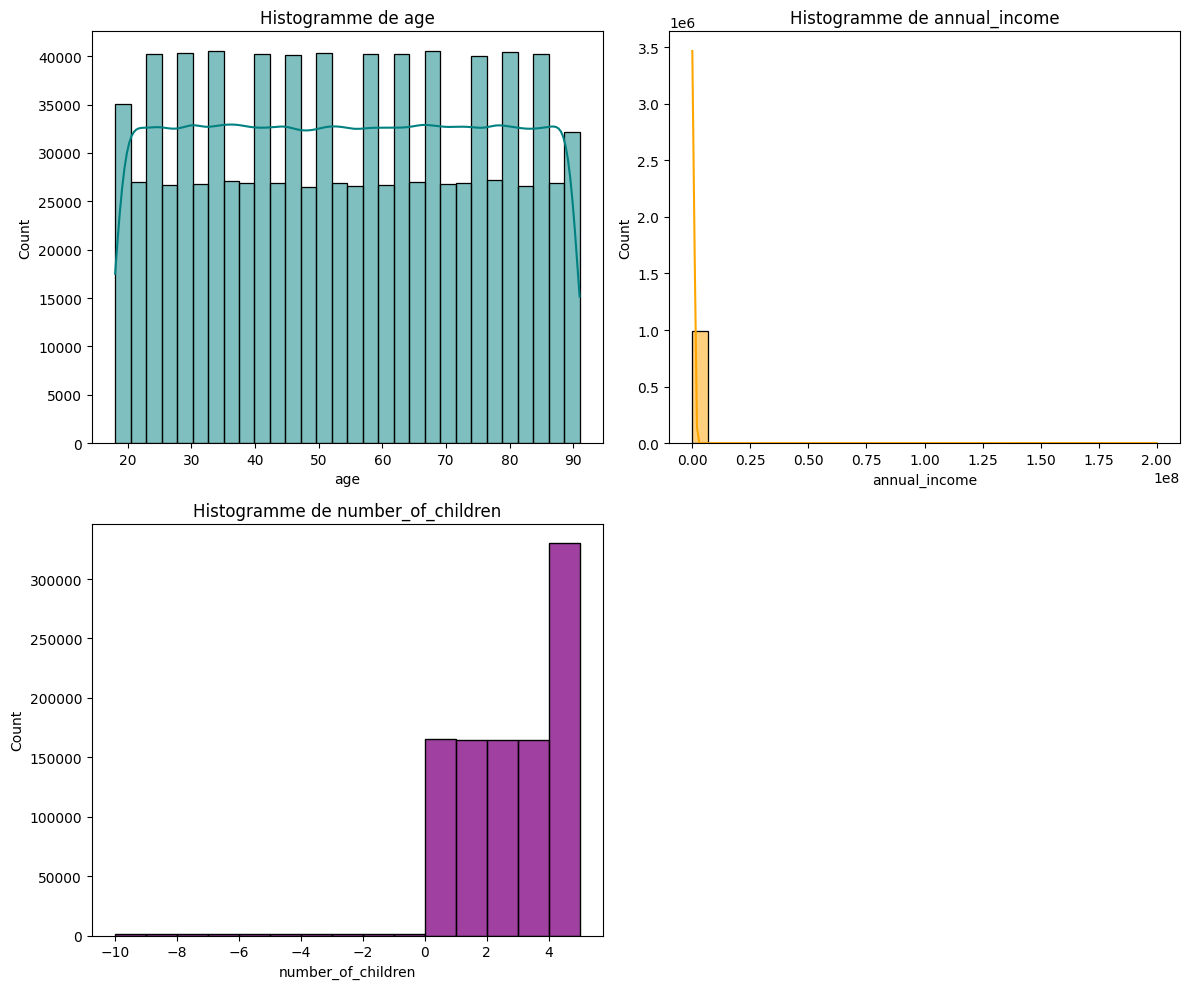

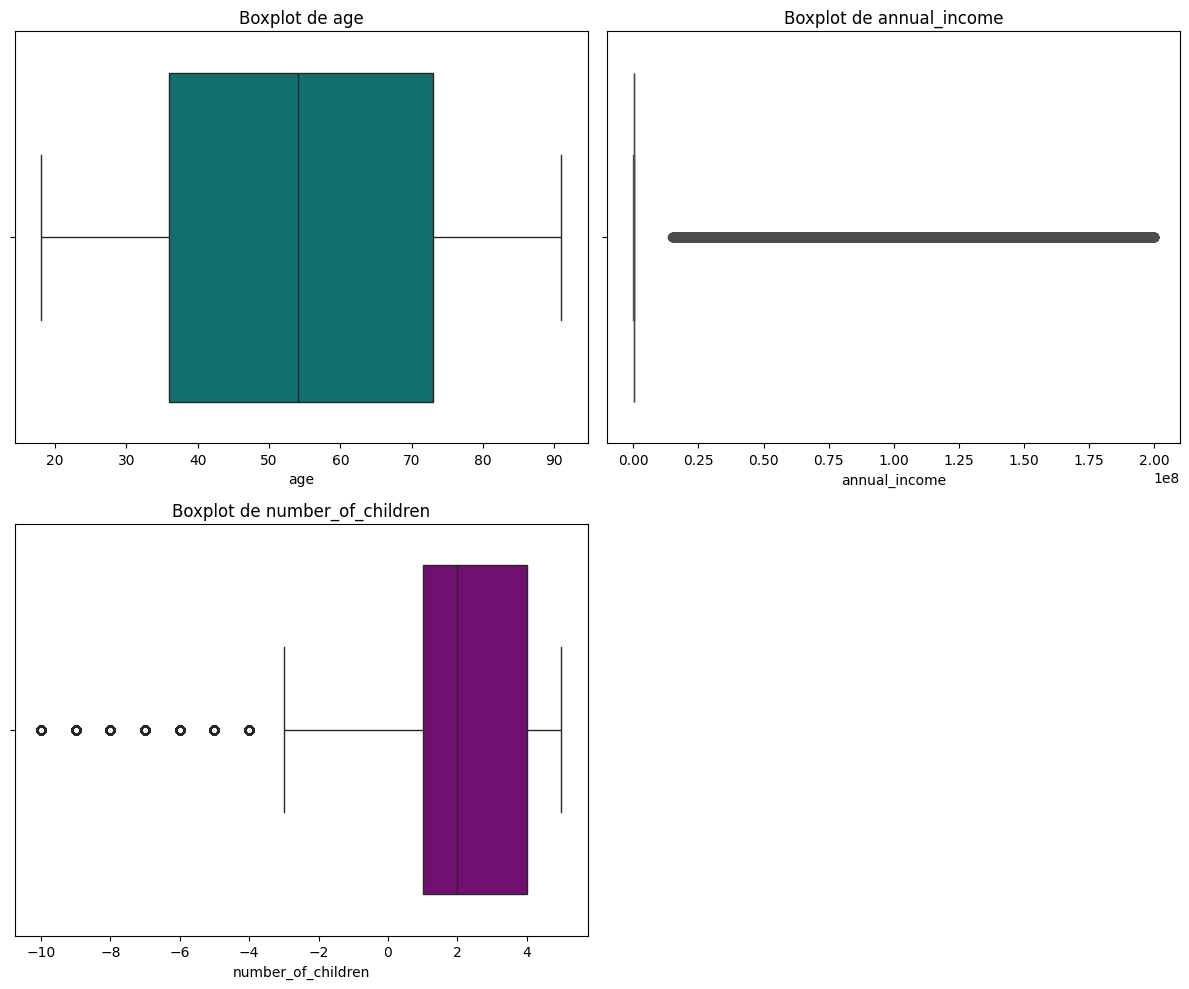

In [19]:
plt.figure(figsize=(12, 10))

# 🔹 Histogramme de age
plt.subplot(2, 2, 1)
sns.histplot(df_customer['age'], color="teal", bins=30, kde=True)
plt.title("Histogramme de age")

# 🔹 Histogramme de annual_income
plt.subplot(2, 2, 2)
sns.histplot(df_customer['annual_income'], color="orange", bins=30, kde=True)
plt.title("Histogramme de annual_income")

# 🔹 Histogramme de number_of_children
plt.subplot(2, 2, 3)
sns.histplot(df_customer['number_of_children'], color="purple", bins=15, kde=False)
plt.title("Histogramme de number_of_children")

plt.tight_layout()
plt.show()

print("\n")

plt.figure(figsize=(12, 10))

# 🔹 Boxplot de age
plt.subplot(2, 2, 1)
sns.boxplot(x=df_customer['age'], color="teal")
plt.title("Boxplot de age")

# 🔹 Boxplot de annual_income
plt.subplot(2, 2, 2)
sns.boxplot(x=df_customer['annual_income'], color="orange")
plt.title("Boxplot de annual_income")

# 🔹 Boxplot de number_of_children
plt.subplot(2, 2, 3)
sns.boxplot(x=df_customer['number_of_children'], color="purple")
plt.title("Boxplot de number_of_children")

plt.tight_layout()
plt.show()

### Resultats d'analyse exploratoire des distributions marginales des variables quantitatives.
- ## age :
- Répartition uniforme : Les âges semblent bien répartis sur toute la plage (environ 18 à 90 ans).
- Aucune anomalie visuelle : Il n’y a pas de pics ou de trous anormaux.
- La courbe de densité (KDE) est globalement plate, ce qui confirme l’uniformité.



- ## annual_income:
- Très forte asymétrie (distribution extrêmement biaisée à droite).
- Presque toutes les valeurs sont très faibles (vers 0), avec quelques revenus extrêmes (outliers) dépassant les 200 millions (soit 2 × 10⁸).
- Cela indique des valeurs aberrantes très élevées, qui doivent être supprimées.
- 
- ## number_of_children :
- On voit des valeurs négatives (jusqu'à -10), ce qui est incohérent.
- Ensuite, on observe une augmentation logique du nombre d’enfants de 0 à 5, avec un pic notable vers 4-5 enfants.
- Anomalies évidentes :
- Le nombre d’enfants ne peut pas être négatif.
- Ces valeurs négatives doivent être supprimées.

### Corrélation entre les variables numériques

In [20]:
df_num = ['age', 'annual_income', 'number_of_children']
df_customer[df_num].corr()

,age,annual_income,number_of_children
age,1.000000,0.000754,-0.001021
annual_income,0.000754,1.000000,-0.000791
number_of_children,-0.001021,-0.000791,1.000000


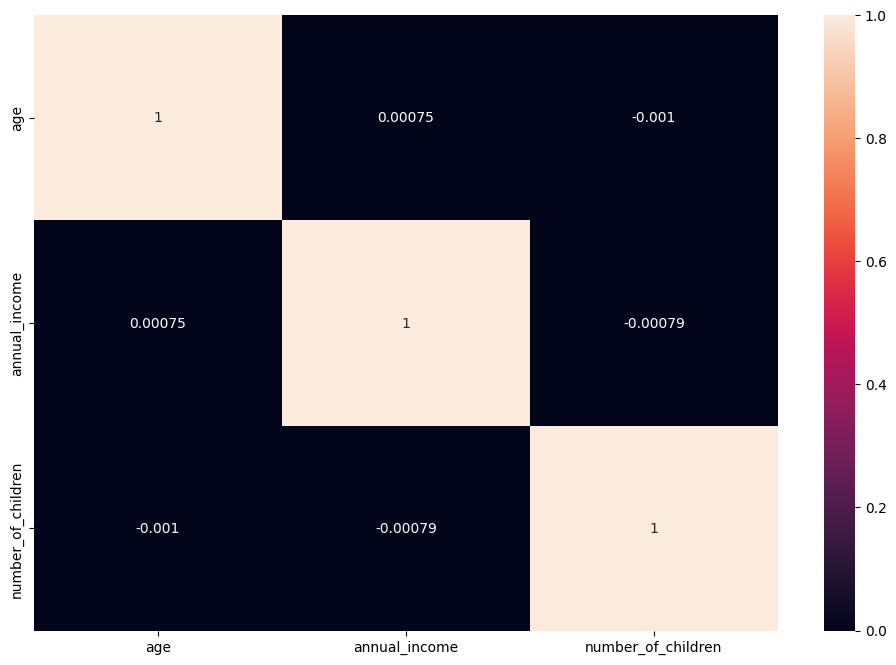

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(df_customer[df_num].corr(), annot=True)
plt.show()

Pas de corrélation entre les variables numériques

# TrainTest-Nettoyage
Objectifs :
- Repartition des données en Trains et test
- Supprimer ou corriger les valeurs aberrantes.

- Préparer les données pour des analyses plus fiables.

In [22]:
# TrainTest 
trainset, testset = train_test_split(df_customer, test_size = 0.2 , random_state=40)

In [23]:
# 1. Nettoyage initial des données
def convert_and_filter_basic(df):
    # Conversion en numérique avec coercition d'erreurs
    cols_to_numeric = ['age', 'annual_income', 'number_of_children']
    for col in cols_to_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Filtrage des âges réalistes
    df = df[(df['age'] >= 18) & (df['age'] <= 91)]
    # Filtrage des revenus positifs
    df = df[df['annual_income'] >= 0]
    # Filtrage nombre d'enfants >= 0
    df = df[df['number_of_children'] >= 0]
    
    return df

# 2. Gestion des outliers et transformation des variables
def handle_outliers_and_transform(df):
    # Suppression des outliers sur revenu annuel (au-delà du 99e percentile)
    income_threshold = df['annual_income'].quantile(0.99)
    df = df[df['annual_income'] <= income_threshold].copy()
    
    # # Transformation logarithmique du revenu annuel
    # df['log_annual_income'] = np.log1p(df['annual_income'])
    
    return df

# 3. Suppression des valeurs manquantes
def remove_missing_values(df, target_col='account_status', predictor_cols=None):
    # Suppression des lignes où la cible est manquante (impératif)
    df = df.dropna(subset=[target_col])
    
    # Si une liste de colonnes prédicteurs est fournie, on supprime les lignes où ces prédicteurs sont manquants
    if predictor_cols is not None:
        df = df.dropna(subset=predictor_cols)
    
    return df

## Feature engineering

In [24]:
# Crétion de groupe d'âges
def create_features(df):
    # Tranches d'âge
    def categorize_age(age):
        if age < 25:
            return '18-24'
        elif age < 35:
            return '25-34'
        elif age < 50:
            return '35-49'
        elif age < 65:
            return '50-64'
        else:
            return '65+'
    
    df['age_group'] = df['age'].apply(categorize_age)
    
    # Taux de charge familiale
    df['children_per_age'] = df['number_of_children'] / df['age']
    df['children_per_age'] = df['children_per_age'].fillna(0)

    # Transformation log du revenu annuel
    df['log_annual_income'] = np.log1p(df['annual_income'])  # log(1 + x) pour éviter log(0)
    # Groupes de revenu selon log revenu
    # if 'log_annual_income' in df.columns:
    #     df['income_group'] = pd.qcut(df['log_annual_income'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

    
    # Suppression de la colonne age si nécessaire (car age_group la remplace)
    df.drop(columns=['age'], inplace=True)
    
    return df


# 5. Visualisation
def plot_age_distribution(df):
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x='age_group')
    plt.title("Répartition par tranche d'âge")
    plt.show()

In [25]:
# pipeline_complet_de_prétraitement
def preprocess_pipeline(df):
    df = convert_and_filter_basic(df)
    df = handle_outliers_and_transform(df)
    # Liste des colonnes prédicteurs importantes pour lesquelles on veut pas de NaN
    predictor_cols = ['age', 'annual_income', 'number_of_children', 'employment_status',
                      'marital_status', 'education_level', 'gender', 'country', 'subscription_type']
    df = remove_missing_values(df, target_col='account_status', predictor_cols=predictor_cols)
    df = create_features(df)
    plot_age_distribution(df)

    X = df.drop(columns=['account_status'])
    y = df['account_status']
    return X, y

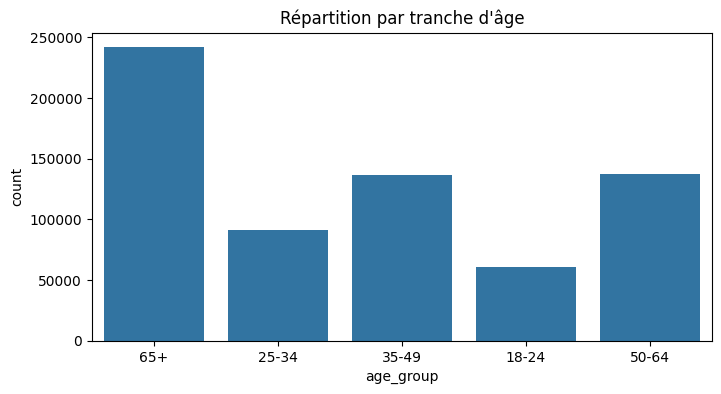

<class 'pandas.core.frame.DataFrame'>
Index: 667179 entries, 501160 to 929094
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   gender              667179 non-null  object 
 1   marital_status      667179 non-null  object 
 2   employment_status   667179 non-null  object 
 3   education_level     667179 non-null  object 
 4   annual_income       667179 non-null  float64
 5   number_of_children  667179 non-null  int64  
 6   country             667179 non-null  object 
 7   subscription_type   667179 non-null  object 
 8   age_group           667179 non-null  object 
 9   children_per_age    667179 non-null  float64
 10  log_annual_income   667179 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 61.1+ MB


In [26]:
# Exécution du pipeline de prétraitement sur les données de test
X_train, y_train = preprocess_pipeline(trainset)

X_train.info()

In [27]:
# On fusionne les données train 
# df_train_cleaned = X_train.copy()
# df_train_cleaned['account_status'] = y_train

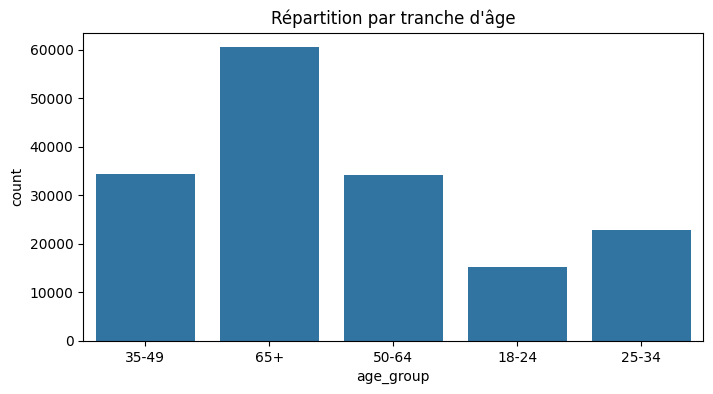

<class 'pandas.core.frame.DataFrame'>
Index: 167049 entries, 884729 to 483739
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   gender              167049 non-null  object 
 1   marital_status      167049 non-null  object 
 2   employment_status   167049 non-null  object 
 3   education_level     167049 non-null  object 
 4   annual_income       167049 non-null  float64
 5   number_of_children  167049 non-null  int64  
 6   country             167049 non-null  object 
 7   subscription_type   167049 non-null  object 
 8   age_group           167049 non-null  object 
 9   children_per_age    167049 non-null  float64
 10  log_annual_income   167049 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 15.3+ MB


In [28]:
# Exécution du pipeline de prétraitement sur les données de test
X_test, y_test = preprocess_pipeline(testset)

X_test.info()

# Data Visualisation.
Suite au prétraitement et au nettoyage des données (traitement des valeurs manquantes, gestion des outliers), une exploration visuelle a été réalisée pour caractériser la structure statistique des variables :

Variables numériques :

- Distribution marginale évaluée via histogrammes (densité, asymétrie, dispersion)

- Détection d’outliers via boxplots, en vue de guider d’éventuelles transformations ou filtrages

Variables catégorielles :

- Analyse de fréquence et déséquilibre des modalités par barplots

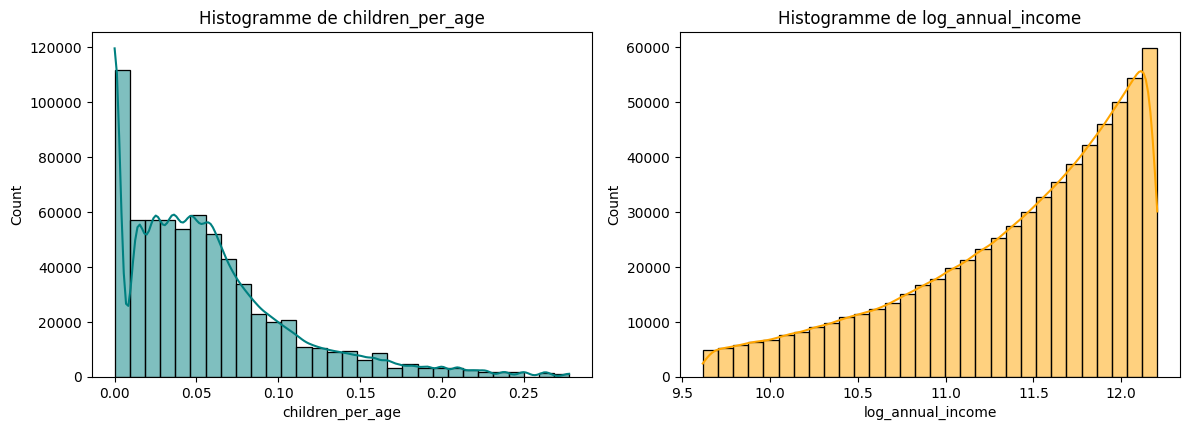

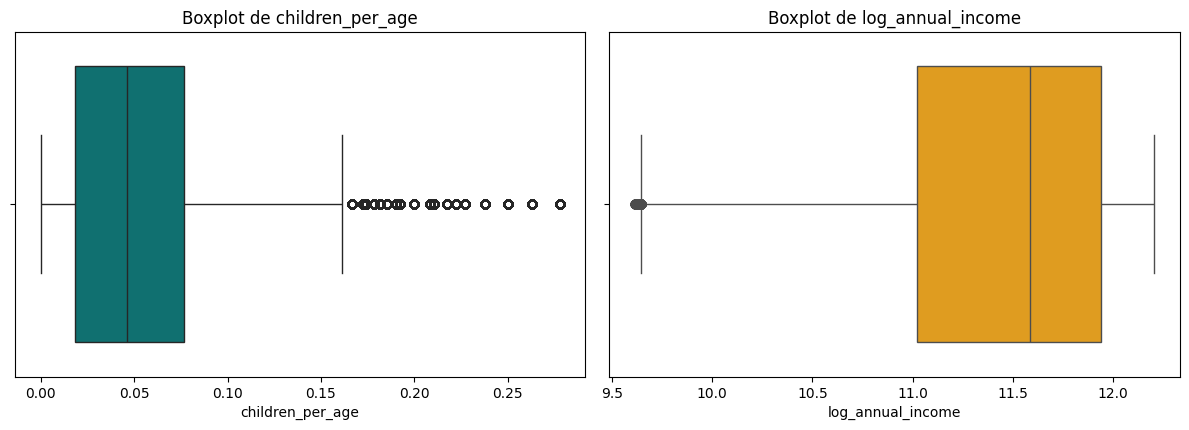

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(X_train['children_per_age'], color="teal", bins=30, kde=True)
plt.title("Histogramme de children_per_age")

plt.subplot(2, 2, 2)
sns.histplot(X_train['log_annual_income'], color="orange", bins=30, kde=True)
plt.title("Histogramme de log_annual_income")

plt.tight_layout()
plt.show()

print("\n")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x=X_train['children_per_age'], color="teal")
plt.title("Boxplot de children_per_age")

plt.subplot(2, 2, 2)
sns.boxplot(x=X_train['log_annual_income'], color="orange")
plt.title("Boxplot de log_annual_income")

plt.tight_layout()
plt.show()

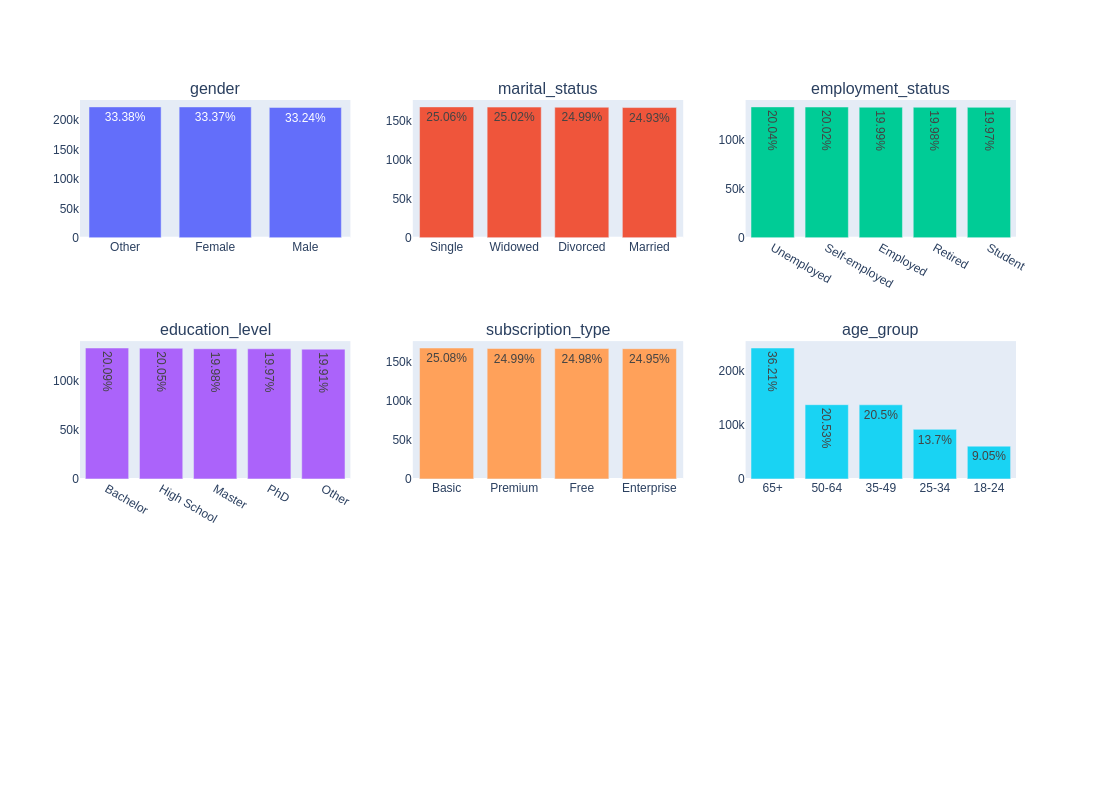

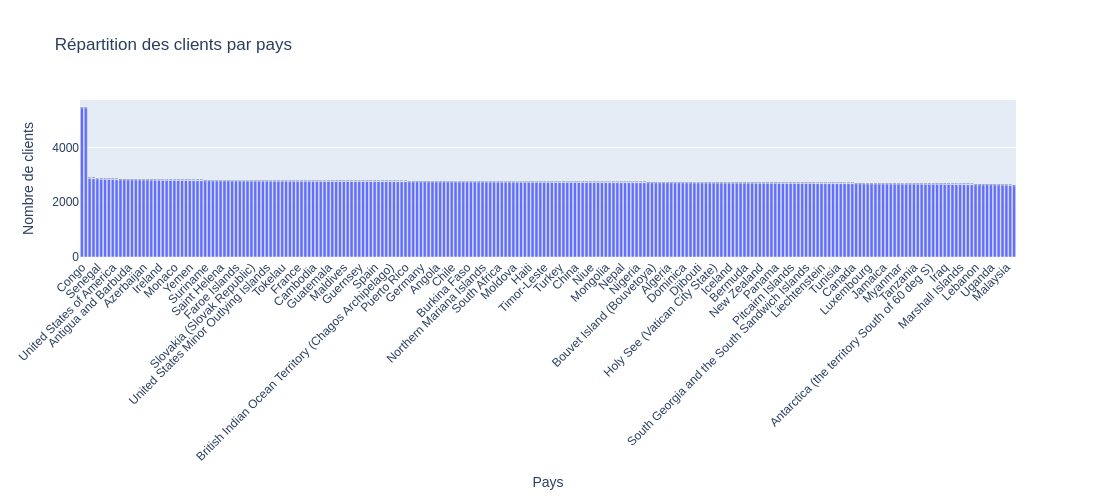

In [30]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cols = ['gender', 'marital_status', 'employment_status', 'education_level', 'subscription_type', 'age_group']

# Paramètres pour afficher en 2 lignes
n_cols = 3
n_rows = 3

fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=cols)

for idx, col in enumerate(cols):
    row = idx // n_cols + 1  # Ligne actuelle (1-based)
    col_position = idx % n_cols + 1  # Colonne actuelle (1-based)
    
    fig.add_trace(
        go.Bar(
            x=X_train[col].value_counts().index,
            y=X_train[col].value_counts(),
            name=col,
            text=[f"{val}%" for val in (X_train[col].value_counts(normalize=True) * 100).round(2)],
            textposition='auto'
        ),
        row=row, col=col_position
    )
    fig.update_xaxes(showgrid=False, row=row, col=col_position)
    fig.update_yaxes(showgrid=False, row=row, col=col_position)

fig.update_layout(height=800, width=1000, showlegend=False)
fig.show()


print("\n")


# Comptage des occurrences par pays
country_counts = X_train['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Diagramme à barres
fig = px.bar(
    country_counts,
    x='country',
    y='count',
    title='Répartition des clients par pays',
    labels={'count': 'Nombre de clients', 'country': 'Pays'},
    text='count'
)

# Mise à jour : texte, angle, taille du graphique
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    width=1000,  # Largeur du graphe augmentée
    height=500   # Optionnel : hauteur personnalisée
)

fig.show()

In [31]:
# On fusionne les données train 
df_train_cleaned = X_train.copy()
df_train_cleaned['account_status'] = y_train
# Sauvegarde dans data/
df_train_cleaned.to_csv("df_train_cleaned.csv", index=False)

df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 667179 entries, 501160 to 929094
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   gender              667179 non-null  object 
 1   marital_status      667179 non-null  object 
 2   employment_status   667179 non-null  object 
 3   education_level     667179 non-null  object 
 4   annual_income       667179 non-null  float64
 5   number_of_children  667179 non-null  int64  
 6   country             667179 non-null  object 
 7   subscription_type   667179 non-null  object 
 8   age_group           667179 non-null  object 
 9   children_per_age    667179 non-null  float64
 10  log_annual_income   667179 non-null  float64
 11  account_status      667179 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 66.2+ MB


In [32]:
# On fusionne les données train 
df_test_cleaned = X_test.copy()
df_test_cleaned['account_status'] = y_test

df_test_cleaned.to_csv("df_test_cleaned.csv", index=False)

df_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167049 entries, 884729 to 483739
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   gender              167049 non-null  object 
 1   marital_status      167049 non-null  object 
 2   employment_status   167049 non-null  object 
 3   education_level     167049 non-null  object 
 4   annual_income       167049 non-null  float64
 5   number_of_children  167049 non-null  int64  
 6   country             167049 non-null  object 
 7   subscription_type   167049 non-null  object 
 8   age_group           167049 non-null  object 
 9   children_per_age    167049 non-null  float64
 10  log_annual_income   167049 non-null  float64
 11  account_status      167049 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 16.6+ MB
